# Web Mining and Applied NLP (44-620)

## Final Project: Spotify API and LyricGenius Analysis

### Student Name: Kellie Leopold [GitHub Link](https://github.com/kjleopold/article-summarizer)

Perform the tasks described in the Markdown cells below.  When you have completed the assignment make sure your code cells have all been run (and have output beneath them) and ensure you have committed and pushed ALL of your changes to your assignment repository.

You should bring in code from previous assignments to help you answer the questions below.

Every question that requires you to write code will have a code cell underneath it; you may either write your entire solution in that cell or write it in a python file (`.py`), then import and run the appropriate code to answer the question.

In [34]:
import json
import pathlib
import pickle
from collections import Counter
import numpy as np

import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import spacy
from spacy.tokens import Doc
from spacytextblob.spacytextblob import SpacyTextBlob
import spotipy
import lyricsgenius
import random
from langdetect import detect, LangDetectException
import os
import re

nlp = spacy.load("en_core_web_sm")
nlp.add_pipe("spacytextblob")

if not Doc.has_extension("polarity"):  
    Doc.set_extension("polarity", getter=lambda doc: doc._.blob.sentiment.polarity)  
  
if not Doc.has_extension("subjectivity"):  
    Doc.set_extension("subjectivity", getter=lambda doc: doc._.blob.sentiment.subjectivity)  
  
if not Doc.has_extension("assessments"):  
    Doc.set_extension("assessments", getter=lambda doc: doc._.blob.sentiment_assessments.assessments)

#### 1. Find on the internet an article or blog post about a topic that interests you and you are able to get the text for using the technologies we have applied in the course.  Get the html for the article and store it in a file (which you must submit with your project)

In [35]:
from get_spotify_token import get_token

# Get access token
ACCESS_TOKEN = get_token()

# Playlist ID
playlist_id = "774kUuKDzLa8ieaSmi8IfS"

# Headers
headers = {
    "Authorization": f"Bearer {ACCESS_TOKEN}"
}

# Endpoint
tracks_url = f"https://api.spotify.com/v1/playlists/{playlist_id}/tracks"

# Authenticated request
response = requests.get(tracks_url, headers=headers)

# Check if it worked
if response.status_code != 200:
    print("Error:", response.status_code, response.json())
else:
    result = response.json()

    # Save to file
    with open('top_hits_2025.json', 'w', encoding='utf-8') as f:
        json.dump(result, f, ensure_ascii=False, indent=4)

    print("Tracks saved to top_hits_2025.json")


Tracks saved to top_hits_2025.json


In [36]:
# Get top 10 songs
# Load JSON file
with open('top_hits_2025.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

# Get the list of tracks
items = data.get('items', [])

# Go through the top 5 songs and print
for i, item in enumerate(items[:10]):
    track_info = item.get('track', {})
    track_name = track_info.get('name', 'Unknown Track')
    artists = [artist['name'] for artist in track_info.get('artists', [])]
    artist_names = ', '.join(artists)

    print(f"{i+1}. {track_name} by {artist_names}")

1. Espresso by Sabrina Carpenter
2. Die With A Smile by Lady Gaga, Bruno Mars
3. BIRDS OF A FEATHER by Billie Eilish
4. Not Like Us by Kendrick Lamar
5. Beautiful Things by Benson Boone
6. we can't be friends (wait for your love) by Ariana Grande
7. Good Luck, Babe! by Chappell Roan
8. Please Please Please by Sabrina Carpenter
9. End of Beginning by Djo
10. APT. by ROSÉ, Bruno Mars


In [37]:
# Get lyrics for a random top 10 song
from dotenv import load_dotenv

# Load environment variables
load_dotenv()
GENIUS_API_TOKEN = os.getenv("GENIUS_API_TOKEN")
if not GENIUS_API_TOKEN:
    raise ValueError("GENIUS_API_TOKEN not found in environment variables")

# Setup Genius
genius = lyricsgenius.Genius(GENIUS_API_TOKEN, timeout=15, retries=3)
genius.skip_non_songs = True
genius.excluded_terms = ["(Remix)", "(Live)"]
genius.remove_section_headers = True

# Load top hits from Spotify JSON
with open('top_hits_2025.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

items = data.get('items', [])
top_10_items = items[:10]

# Choose song from top 10
track_name = "Beautiful Things"
artist_names = "Benson Boone"

# Fetch lyrics
try:
    song = genius.search_song(track_name, artist_names)
    if song and song.lyrics:
        lyrics = song.lyrics
    else:
        lyrics = "Lyrics not found."
except Exception as e:
    lyrics = f"Error fetching lyrics: {str(e)}"

# Clean out translation/contributor lines
lyrics_clean = re.sub(r'\n?\d+\s+Contributors.*', '', lyrics)
lyrics_clean = re.sub(r'Translations.*', '', lyrics_clean)

# Print pretty snippet (first 300 characters)
snippet_length = 300
snippet = lyrics_clean.strip()[:snippet_length]
if len(lyrics_clean) > snippet_length:
    snippet += "..."

print("\n Lyrics Snippet:\n")
print(snippet)

# Save to JSON
song_data = {
    "artist": artist_names,
    "title": track_name,
    "lyrics": lyrics_clean.strip()
}

safe_title = "".join(c for c in track_name if c.isalnum() or c in (' ', '_')).strip()
filename = f"{safe_title}.json"

with open(filename, "w", encoding="utf-8") as json_file:
    json.dump(song_data, json_file, ensure_ascii=False, indent=2)

print(f"\n Saved lyrics to '{filename}'")

Searching for "Beautiful Things" by Benson Boone...
Done.

 Lyrics Snippet:

For a while there, it was rough
But lately, I've been doin' better
Than the last four cold Decembers I recall
And I see my family every month
I found a girl my parents love
She'll come and stay the night, and I think I might have it all
And I thank God every day
For the girl He sent my way
But I kno...

 Saved lyrics to 'Beautiful Things.json'


#### 2. Read in your article's html source from the file you created in question 1 and do sentiment analysis on the article/post's text (use `.get_text()`).  Print the polarity score with an appropriate label.  Additionally print the number of sentences in the original article (with an appropriate label)

In [38]:
safe_title = "".join(c for c in track_name if c.isalnum() or c in (' ', '_')).strip()
filename = f"{safe_title}.json"

# Load song data from file
with open(filename, 'r', encoding='utf-8') as f:
    song_data = json.load(f)

lyrics = song_data.get("lyrics", "")
song_title = song_data.get("title", "Unknown Title")
artist = song_data.get("artist", "Unknown Artist")

# Analyze with spaCyTextBlob
doc = nlp(lyrics)
polarity = doc._.polarity
num_sentences = len(list(doc.sents))

# Label sentiment
if polarity > 0.1:
    label = "Positive"
elif polarity < -0.1:
    label = "Negative"
else:
    label = "Neutral"

# Print results
print(f"\nSentiment Analysis for: '{song_title}' by {artist}")
print(f"File: {filename}")
print(f"Sentiment Polarity: {polarity:.2f} ({label})")
print(f"Number of Sentences: {num_sentences}")


Sentiment Analysis for: 'Beautiful Things' by Benson Boone
File: Beautiful Things.json
Sentiment Polarity: 0.39 (Positive)
Number of Sentences: 21


#### 3. Load the article text into a trained `spaCy` pipeline, and determine the 5 most frequent tokens (converted to lower case).  Print the common tokens with an appropriate label.  Additionally, print the tokens their frequencies (with appropriate labels)

In [39]:
# Process the lyrics text
doc = nlp(lyrics)

# Extract tokens: lowercase, remove punctuation, spaces, and stop words
tokens = [token.text.lower() for token in doc
          if not token.is_punct and not token.is_space and not token.is_stop]

# Count token frequencies
token_freq = Counter(tokens)

# Get top 5 most common tokens
most_common_tokens = token_freq.most_common(5)

print("\nTop 5 most frequent tokens in the lyrics:")
for token, freq in most_common_tokens:
    print(f"Token: '{token}' - Frequency: {freq}")


Top 5 most frequent tokens in the lyrics:
Token: 'oh' - Frequency: 8
Token: 'got' - Frequency: 7
Token: 'stay' - Frequency: 5
Token: 'god' - Frequency: 5
Token: 'things' - Frequency: 5


#### 4. Load the article text into a trained `spaCy` pipeline, and determine the 5 most frequent lemmas (converted to lower case).  Print the common lemmas with an appropriate label.  Additionally, print the lemmas with their frequencies (with appropriate labels).

In [40]:
# Extract lemmas: lowercase, filter out punctuation, spaces, and stop words
lemmas = [token.lemma_.lower() for token in doc
          if not token.is_punct and not token.is_space and not token.is_stop]

# Count lemma frequencies
lemma_freq = Counter(lemmas)

# Get top 5 most common lemmas
most_common_lemmas = lemma_freq.most_common(5)

print("\nTop 5 most frequent lemmas in the lyrics:")
for lemma, freq in most_common_lemmas:
    print(f"Lemma: '{lemma}' - Frequency: {freq}")


Top 5 most frequent lemmas in the lyrics:
Lemma: 'oh' - Frequency: 8
Lemma: 'get' - Frequency: 7
Lemma: 'stay' - Frequency: 5
Lemma: 'god' - Frequency: 5
Lemma: 'thing' - Frequency: 5


#### 5. Make a list containing the scores (using tokens) of every sentence in the article, and plot a histogram with appropriate titles and axis labels of the scores. From your histogram, what seems to be the most common range of scores (put the answer in a comment after your code)?

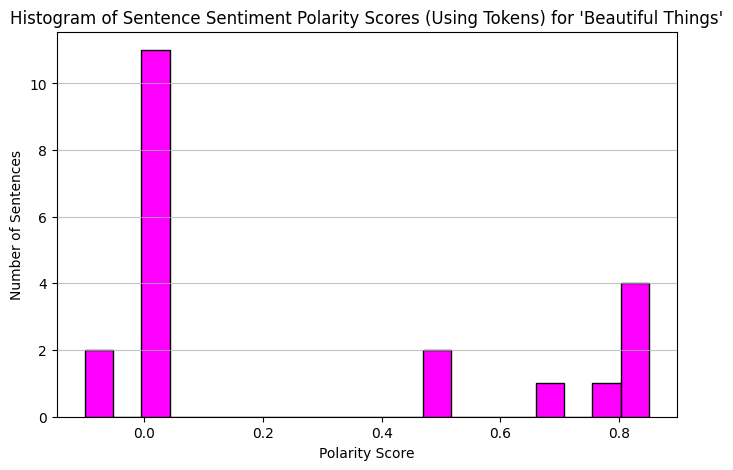

In [41]:
# Load spaCy model and add pipe
nlp = spacy.load("en_core_web_sm")
nlp.add_pipe("spacytextblob")

filename = f"{safe_title}.json"

with open(filename, 'r', encoding='utf-8') as f:
    song_data = json.load(f)

lyrics = song_data.get("lyrics", "")

# Process full lyrics
doc = nlp(lyrics)

# Get polarity scores for each sentence by processing each sentence text individually
sentence_scores_tokens = []
for sent in doc.sents:
    sent_doc = nlp(sent.text)
    sentence_scores_tokens.append(sent_doc._.polarity)

# Plot histogram
plt.figure(figsize=(8,5))
plt.hist(sentence_scores_tokens, bins=20, color='magenta', edgecolor='black')
plt.title(f"Histogram of Sentence Sentiment Polarity Scores (Using Tokens) for '{song_data.get('title')}'")
plt.xlabel("Polarity Score")
plt.ylabel("Number of Sentences")
plt.grid(axis='y', alpha=0.75)
plt.show()

# Based on the histogram, the most common range of scores appears to be around 0 to 0.1

#### 6. Make a list containing the scores (using lemmas) of every sentence in the article, and plot a histogram with appropriate titles and axis labels of the scores.  From your histogram, what seems to be the most common range of scores (put the answer in a comment after your code)?

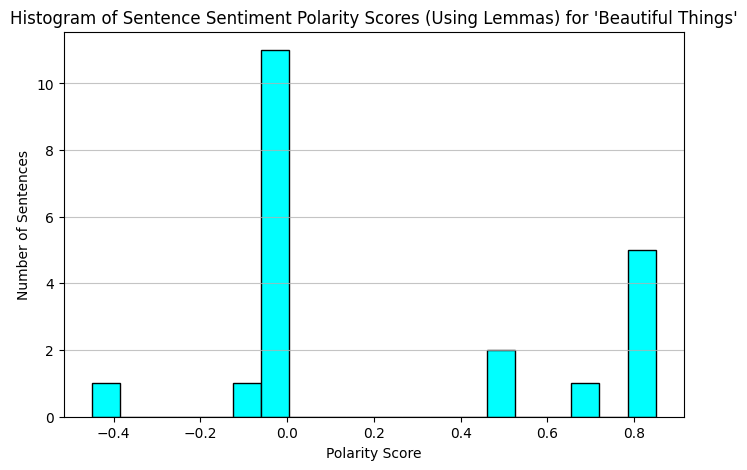

In [42]:
# Load spaCy model and add TextBlob pipe
nlp = spacy.load("en_core_web_sm")
nlp.add_pipe("spacytextblob")

filename = f"{safe_title}.json"

with open(filename, 'r', encoding='utf-8') as f:
    song_data = json.load(f)

lyrics = song_data.get("lyrics", "")

# Process full lyrics
doc = nlp(lyrics)

sentence_scores_lemmas = []
for sent in doc.sents:
    # Extract lemmas, filtering out punctuation, spaces, stop words
    lemmas = [token.lemma_ for token in sent
              if not token.is_punct and not token.is_space and not token.is_stop]
    
    # Join lemmas into string for sentiment analysis
    lemma_text = " ".join(lemmas)
    
    # Run sentiment analysis on lemma text
    sent_doc = nlp(lemma_text)
    sentence_scores_lemmas.append(sent_doc._.polarity)

# Plot histogram for lemma-based sentence scores
plt.figure(figsize=(8,5))
plt.hist(sentence_scores_lemmas, bins=20, color='aqua', edgecolor='black')
plt.title(f"Histogram of Sentence Sentiment Polarity Scores (Using Lemmas) for '{song_data.get('title')}'")
plt.xlabel("Polarity Score")
plt.ylabel("Number of Sentences")
plt.grid(axis='y', alpha=0.75)
plt.show()

# Comment:
# The histogram shows the distribution of sentiment polarity scores based on lemmas to be -0.1 to 0.0


#### 7. Using the histograms from questions 5 and 6, decide a "cutoff" score for tokens and lemmas such that fewer than half the sentences would have a score greater than the cutoff score.  Record the scores in this Markdown cell. Feel free to change these scores as you generate your summaries.  Ideally, we're shooting for at least 6 sentences for our summary, but don't want more than 10 (these numbers are rough estimates; they depend on the length of your article).

* Cutoff Score (tokens): 0.1
* Cutoff Score (lemmas): 0.1

#### 8. Create a summary of the article by going through every sentence in the article and adding it to an (initially) empty list if its score (based on tokens) is greater than the cutoff score you identified in question 8.  If your loop variable is named `sent`, you may find it easier to add `sent.text.strip()` to your list of sentences.  Print the summary (I would cleanly generate the summary text by `join`ing the strings in your list together with a space (`' '.join(sentence_list)`).

In [43]:
from textblob import TextBlob
import spacy

# Load spaCy model
nlp = spacy.load("en_core_web_sm")

# Load the saved lyrics file
import json
with open("Beautiful Things.json", "r", encoding="utf-8") as f:
    song_data = json.load(f)

lyrics_text = song_data["lyrics"]

# Process the lyrics
doc = nlp(lyrics_text)

# Cutoff score from Q7
cutoff_score = 0.1

# Create summary list
summary_sentences = []

for sent in doc.sents:
    polarity = TextBlob(sent.text).sentiment.polarity
    if polarity > cutoff_score:
        summary_sentences.append(sent.text.strip())

# Create clean summary text
summary_text = ' '.join(summary_sentences)

print("Summary:\n")
print(summary_text)

Summary:

And I see my family every month
I found a girl my parents love oh God
Don't take
Thеse beautiful things that I've got

Please stay
I want you, I need you, oh God
Don't take
These beautiful things that I've got

Oh, ooh It's been a while, but I'm finding my faith
If everything's good and it's great, why do I sit and wait 'til it's gone? and I've got love oh God
Don't take
These beautiful things that I've got

Oh, ooh

Please stay
I want you, I need you, oh God
I need
These beautiful things that I've got


#### 9. Print the polarity score of your summary you generated with the token scores (with an appropriate label). Additionally, print the number of sentences in the summarized article.

In [44]:
# Calculate polarity score of the summary text
summary_polarity = TextBlob(summary_text).sentiment.polarity

# Count the number of sentences in the summary
num_summary_sentences = len(summary_sentences)

print(f"Polarity score of the summary: {summary_polarity:.3f}")
print(f"Number of sentences in the summary: {num_summary_sentences}")

Polarity score of the summary: 0.737
Number of sentences in the summary: 8


#### 10. Create a summary of the article by going through every sentence in the article and adding it to an (initially) empty list if its score (based on lemmas) is greater than the cutoff score you identified in question 8.  If your loop variable is named `sent`, you may find it easier to add `sent.text.strip()` to your list of sentences.  Print the summary (I would cleanly generate the summary text by `join`ing the strings in your list together with a space (`' '.join(sentence_list)`).

In [45]:
# Cutoff score from Q8 (lemma-based)
cutoff_score = 0.1

summary_sentences_lemmas = []

for sent in doc.sents:
    # Create a string from lemmas of the tokens in the sentence
    lemma_text = ' '.join([token.lemma_ for token in sent])
    
    # Calculate polarity based on lemma text
    polarity = TextBlob(lemma_text).sentiment.polarity
    
    if polarity > cutoff_score:
        summary_sentences_lemmas.append(sent.text.strip())

# Create clean summary text from lemma-based sentence list
summary_text_lemmas = ' '.join(summary_sentences_lemmas)

print("Lemma-based Summary:\n")
print(summary_text_lemmas)

Lemma-based Summary:

And I see my family every month
I found a girl my parents love oh God
Don't take
Thеse beautiful things that I've got

Please stay
I want you, I need you, oh God
Don't take
These beautiful things that I've got

Oh, ooh It's been a while, but I'm finding my faith
If everything's good and it's great, why do I sit and wait 'til it's gone? and I've got love oh God
Don't take
These beautiful things that I've got

Oh, ooh

Please stay
I want you, I need you, oh God
I need
These beautiful things that I've got


#### 11. Print the polarity score of your summary you generated with the lemma scores (with an appropriate label). Additionally, print the number of sentences in the summarized article.

In [46]:
# Calculate polarity score of the lemma-based summary text
summary_lemmas_polarity = TextBlob(summary_text_lemmas).sentiment.polarity

# Count the number of sentences in the lemma-based summary
num_summary_lemmas_sentences = len(summary_sentences_lemmas)

print(f"Polarity score of the lemma-based summary: {summary_lemmas_polarity:.3f}")
print(f"Number of sentences in the lemma-based summary: {num_summary_lemmas_sentences}")

Polarity score of the lemma-based summary: 0.737
Number of sentences in the lemma-based summary: 8


#### 12.  Compare your polarity scores of your summaries to the polarity scores of the initial article.  Is there a difference?  Why do you think that may or may not be?.  Answer in this Markdown cell.

**Answer**: The polarity scores are exactly the same. There isn't much variation in the words and structure of song lyrics, so it would make sense that they are same.

#### 13. Based on your reading of the original article, which summary do you think is better (if there's a difference).  Why do you think this might be?

**Answer**: There wasn't a difference between the two summaries for the reasons stated in question 12. Due to that fact, neither summary is better than the other.

In [47]:
# Export to HTML
!jupyter nbconvert --to html spotify-api-lyric-analysis.ipynb

[NbConvertApp] Converting notebook spotify-api-lyric-analysis.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 2 image(s).
[NbConvertApp] Writing 406399 bytes to spotify-api-lyric-analysis.html
